CT Reconstruction with CG and PCG
=================================

This example demonstrates a simple iterative CT reconstruction using
conjugate gradient (CG) and preconditioned conjugate gradient (PCG)
algorithms to solve the problem

  $$\mathrm{argmin}_{\mathbf{x}} \; (1/2) \| \mathbf{y} - A \mathbf{x}
  \|_2^2 \;,$$

where $A$ is the Radon transform, $\mathbf{y}$ is the sinogram, and
$\mathbf{x}$ is the reconstructed image.

In [1]:
from time import time

import numpy as np

import jax
import jax.numpy as jnp

from xdesign import Foam, discrete_phantom

from scico import loss, plot
from scico.linop import CircularConvolve
from scico.linop.radon_astra import TomographicProjector
from scico.solver import cg
plot.config_notebook_plotting()

Create a ground truth image.

In [2]:
N = 256  # phantom size
x_gt = discrete_phantom(Foam(size_range=[0.075, 0.0025], gap=1e-3, porosity=1), size=N)
x_gt = jax.device_put(x_gt)  # convert to jax type, push to GPU

Configure a CT projection operator and generate synthetic measurements.

In [3]:
n_projection = N  # matches the phantom size so this is not few-view CT
angles = np.linspace(0, np.pi, n_projection)  # evenly spaced projection angles
A = 1 / N * TomographicProjector(x_gt.shape, 1, N, angles)  # Radon transform operator
y = A @ x_gt  # sinogram

Forward and back project a single pixel (Kronecker delta) to compute
an approximate impulse response for $\mathbf{A}^T \mathbf{A}$.

In [4]:
H = CircularConvolve.from_operator(A.T @ A)

Invert in the Fourier domain to form a preconditioner $\mathbf{M}
\approx (\mathbf{A}^T \mathbf{A})^{-1}$. See
<cite data-cite="clinthorne-1993-preconditioning"/> Section V.A. for more details.

In [5]:
# γ limits the gain of the preconditioner; higher gives a weaker filter.
γ = 1e-2

# The imaginary part comes from numerical errors in A.T and needs to be
# removed to ensure H is symmetric, positive definite.
frequency_response = np.real(H.h_dft)
inv_frequency_response = 1 / (frequency_response + γ)
# Using circular convolution without padding is sufficient here because
# M is approximate anyway.
M = CircularConvolve(inv_frequency_response, x_gt.shape, h_is_dft=True)

Check that $\mathbf{M}$ does approximately invert $\mathbf{A}^T \mathbf{A}$.

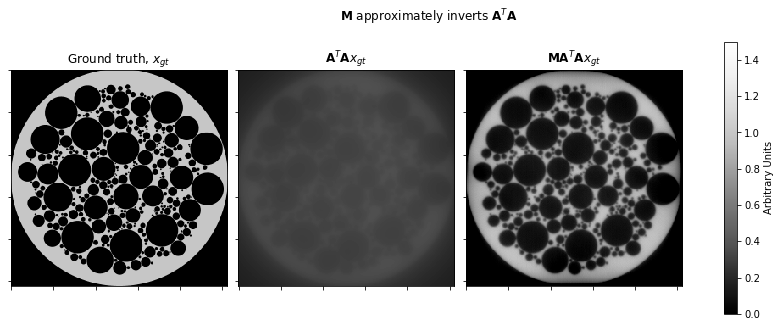

In [6]:
plot_args = dict(norm=plot.matplotlib.colors.Normalize(vmin=0, vmax=1.5))

fig, axes = plot.subplots(nrows=1, ncols=3, figsize=(12, 4.5))
plot.imview(x_gt, title="Ground truth, $x_{gt}$", fig=fig, ax=axes[0], **plot_args)
plot.imview(
    A.T @ A @ x_gt, title=r"$\mathbf{A}^T \mathbf{A} x_{gt}$", fig=fig, ax=axes[1], **plot_args
)
plot.imview(
    M @ A.T @ A @ x_gt,
    title=r"$\mathbf{M} \mathbf{A}^T \mathbf{A} x_{gt}$",
    fig=fig,
    ax=axes[2],
    **plot_args,
)
fig.suptitle(r"$\mathbf{M}$ approximately inverts $\mathbf{A}^T \mathbf{A}$")
fig.tight_layout()
fig.colorbar(
    axes[2].get_images()[0],
    ax=axes,
    location="right",
    shrink=1.0,
    pad=0.05,
    label="Arbitrary Units",
)
fig.show()

Reconstruct with both standard and preconditioned conjugate gradient.

In [7]:
start_time = time()
x_cg, info_cg = cg(
    A.T @ A,
    A.T @ y,
    jnp.zeros(A.input_shape, dtype=A.input_dtype),
    tol=1e-5,
    info=True,
)
time_cg = time() - start_time

start_time = time()
x_pcg, info_pcg = cg(
    A.T @ A,
    A.T @ y,
    jnp.zeros(A.input_shape, dtype=A.input_dtype),
    tol=2e-5,  # preconditioning affects the problem scaling so tol differs between CG and PCG
    info=True,
    M=M,
)
time_pcg = time() - start_time

Compare CG and PCG in terms of reconstruction time and data fidelity.

In [8]:
f_cg = loss.SquaredL2Loss(y=A.T @ y, A=A.T @ A)
f_data = loss.SquaredL2Loss(y=y, A=A)
print(
    f"{'Method':10s}{'Iterations':>15s}{'Time (s)':>15s}{'||ATAx - ATy||':>15s}{'||Ax - y||':>15s}"
)
print(
    f"{'CG':10s}{info_cg['num_iter']:>15d}{time_cg:>15.2f}{f_cg(x_cg):>15.2e}{f_data(x_cg):>15.2e}"
)
print(
    f"{'PCG':10s}{info_pcg['num_iter']:>15d}{time_pcg:>15.2f}{f_cg(x_pcg):>15.2e}"
    f"{f_data(x_pcg):>15.2e}"
)

Method         Iterations       Time (s) ||ATAx - ATy||     ||Ax - y||


CG                    170          14.26       2.57e-07       8.19e-04
PCG                    68           4.27       4.78e-08       3.14e-04
